# Pre-chosen apertures

Using the interactive visualisation tool created for assessing the red noise properties of NGTS lightcurves, I hand picked which had a visible trend, and I picked stars without. The trend was assessed in data binned to 100 points (~16 minutes) and stars were chosen between a mean flux range of 1E4 to 1E5.

In this investigation I consider these things:

1. do the stars with trends travel further through field rotation or atmospheric refraction?
1. do the stars with trends have more or closer companions?
1. are the stars with trends a particular colour?
1. how are the stars with trends distributed across the chip?

First some imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os
import fitsio
import pandas as pd
from astropy.stats import sigma_clip
from astropy.visualization import scale_image
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
from sqlalchemy import create_engine
sys.path.insert(0, '..')
# function to bin a numpy array in 2d rather than iterating over lightcurves
from binmodule import fast_bin
from collections import namedtuple
from matplotlib.collections import PatchCollection
from scipy.spatial import KDTree
from photutils import CircularAperture, aperture_photometry
import glob
from concurrent.futures import ProcessPoolExecutor
from functools import partial

np.random.seed(42)
sns.set(style='ticks', context='poster', palette='Set2')
colours = sns.color_palette()

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, al

Define our aperture list. These apertures have come from my manual selection process.

In [2]:
aperture_list = pd.read_csv('./lightcurves.csv')
print('%d objects, %d with trend, %d without' % (
        len(aperture_list), len(aperture_list[aperture_list['trend'] == 1]),
        len(aperture_list[aperture_list['trend'] == 0])))
# Convert aperture_list trend column to categorical
aperture_list['trend'] = pd.Categorical(['with' if i == 1 else 'without' for i in aperture_list['trend']])
aperture_list.sort_values(by='trend').head(10)

80 objects, 44 with trend, 36 without


,aperture,trend
0,3628,with
34,7229,with
35,10417,with
36,2977,with
78,12650,with
40,16333,with
41,4160,with
42,7707,with
43,5089,with
44,15269,with


Now from the extracted output file, for each of the lightcurves in our list, compute the x/y position for the given frame (and for sanity extract the coordinates based on its ra/dec coordinates also). I do not recall when I changed the pipeline to render the aperture coordinates rather than the centroided positions, so to be safe I recompute the aperture positions from the astrometric solution. This does beg the question: are they consistent but that question can hopefully be answered separately (and soon!).

In [3]:
extracted_fname = '/ngts/pipedev/ParanalOutput/nightly_data/20150911-ng2000-802-custom-flat-high-quality.fits'
# Skip the first N frames to reject the field acquisition
skip = 30
with fitsio.FITS(extracted_fname) as infile:
    catalogue = infile['catalogue'].read()
    imagelist = infile['imagelist'].read()[skip:]
    flux = infile['tamflux'][:, skip:]
    ccdx = infile['ccdx'][:, skip:]
    ccdy = infile['ccdy'][:, skip:]

## Compute flux stats

For each object in the sample, compute the median flux and fractional rms.

In [4]:
lcs = np.array([flux[i] for i in aperture_list['aperture']])
sc_lcs = sigma_clip(lcs, axis=1, iters=2)
binned_lcs = fast_bin(sc_lcs, 100)
med_flux = np.median(binned_lcs, axis=1)
mad_flux = np.median(np.abs(binned_lcs - med_flux[:, np.newaxis]), axis=1)
frms = 1.48 * mad_flux / med_flux
aperture_list['med_flux'] = med_flux
aperture_list['frms'] = frms

## Compute positional stats

Also compute the difference between the 5th and 95th percentile to get the approximate distance traveled. This method is robust to outlier points, and has proven a good metric for distance traveled.

Then also compute the vector magnitude of the distance travelled.

In [5]:
ccdx_sample = np.array([ccdx[i] for i in aperture_list['aperture']])
ccdy_sample = np.array([ccdy[i] for i in aperture_list['aperture']])

aperture_list['distance_x'] = np.abs(np.diff(np.percentile(ccdx_sample, [5, 95], axis=1).T))
aperture_list['distance_y'] = np.abs(np.diff(np.percentile(ccdy_sample, [5, 95], axis=1).T))
aperture_list['distance_r'] = np.sqrt(aperture_list['distance_x'] ** 2 + aperture_list['distance_y'] ** 2)

Let's visualise what we have so far. First the fractional rms for the stars with and without trends, as a function of distance traveled.

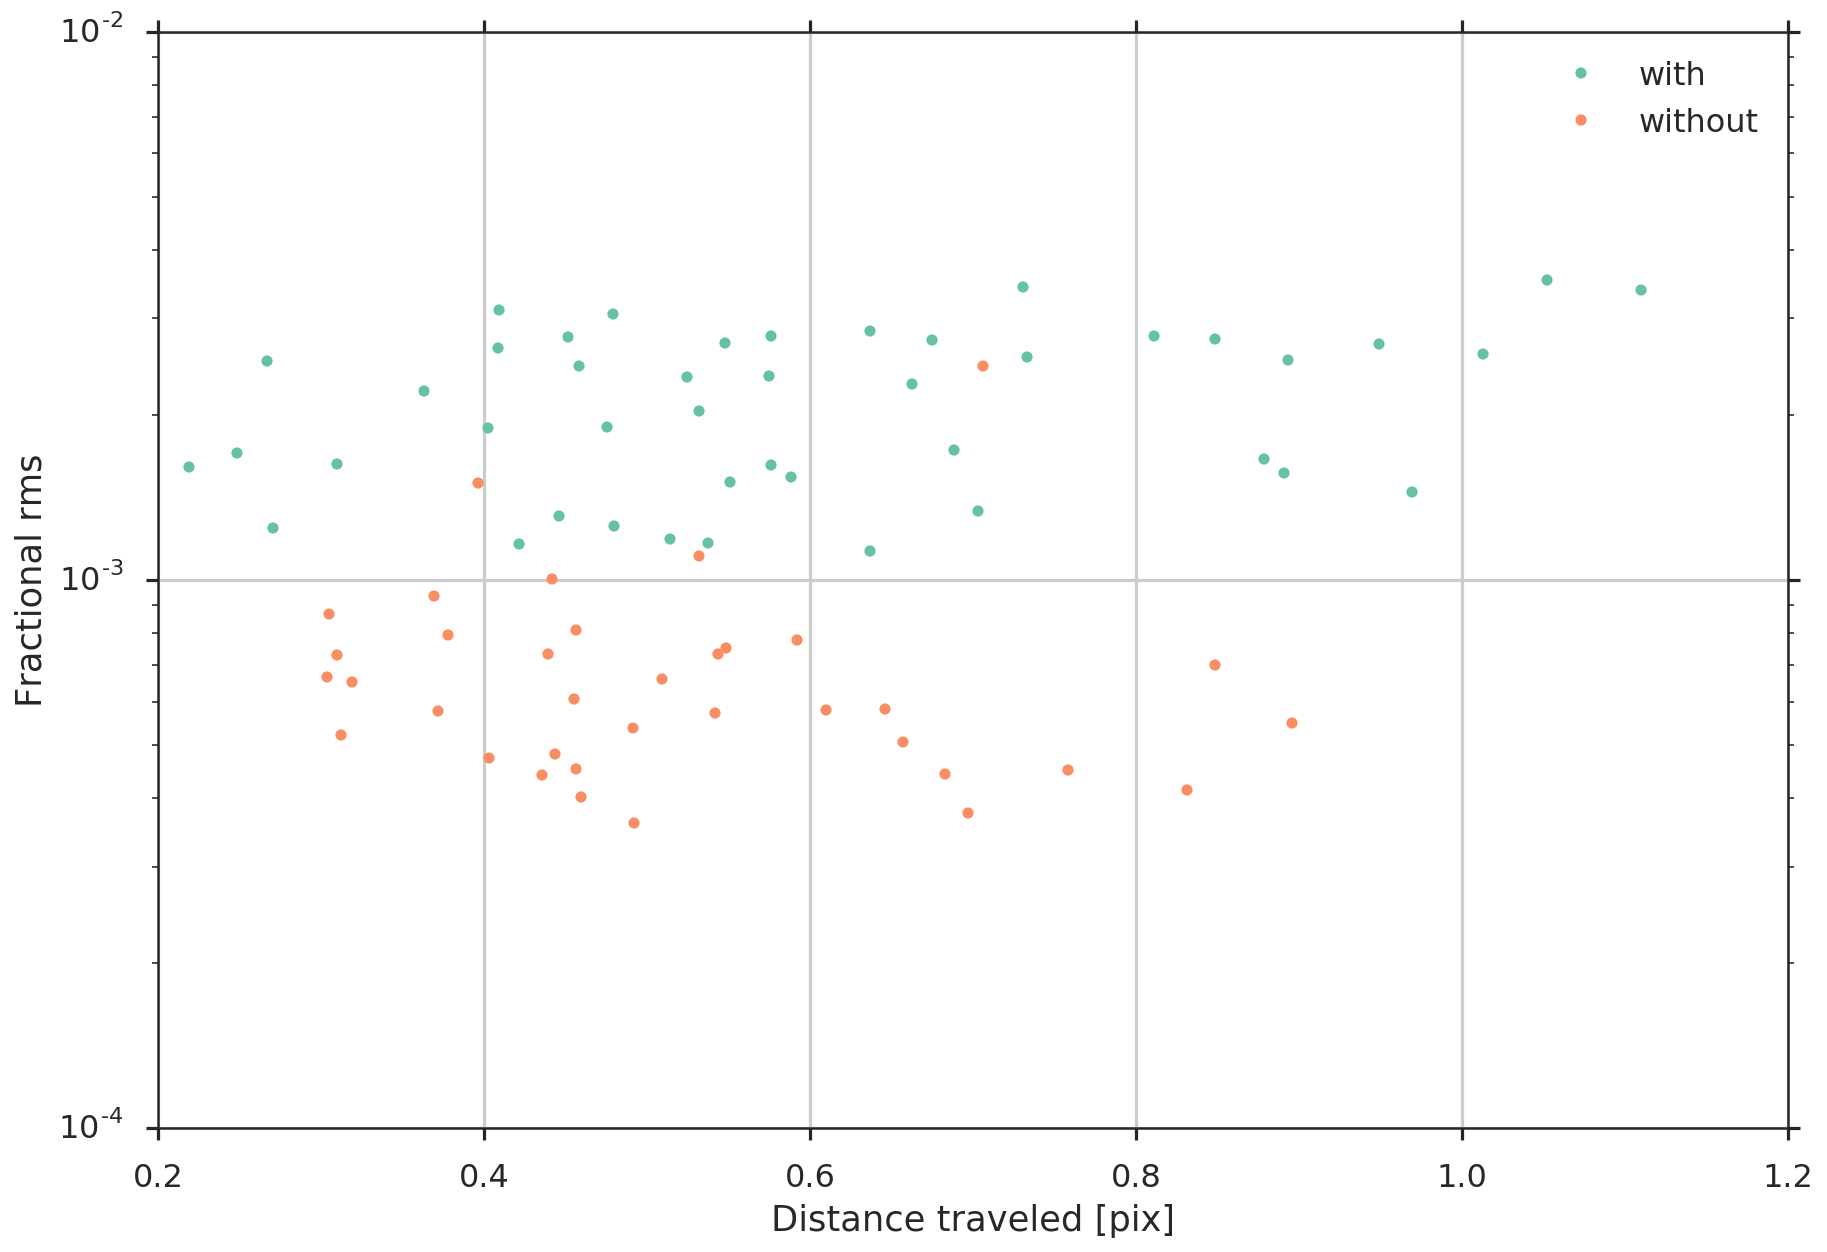

In [6]:
fig, ax = plt.subplots()
for trend, group in aperture_list.groupby('trend'):
    ax.plot(group['distance_r'], group['frms'], '.', label=trend)
ax.set(yscale='log', xlabel='Distance traveled [pix]', ylabel='Fractional rms')
ax.grid(True)
ax.legend(loc='best')
fig.tight_layout()

Clearly the stars with trends have higher frms - that's how they were chosen.There is perhaps a slight trend for the stars with trends. Since Dan found a possible trend with RA, perhaps this is the key.

In [7]:
aperture_list['ra'] = np.array([catalogue['RA'][i] for i in aperture_list['aperture']])
aperture_list['dec'] = np.array([catalogue['DEC'][i] for i in aperture_list['aperture']])

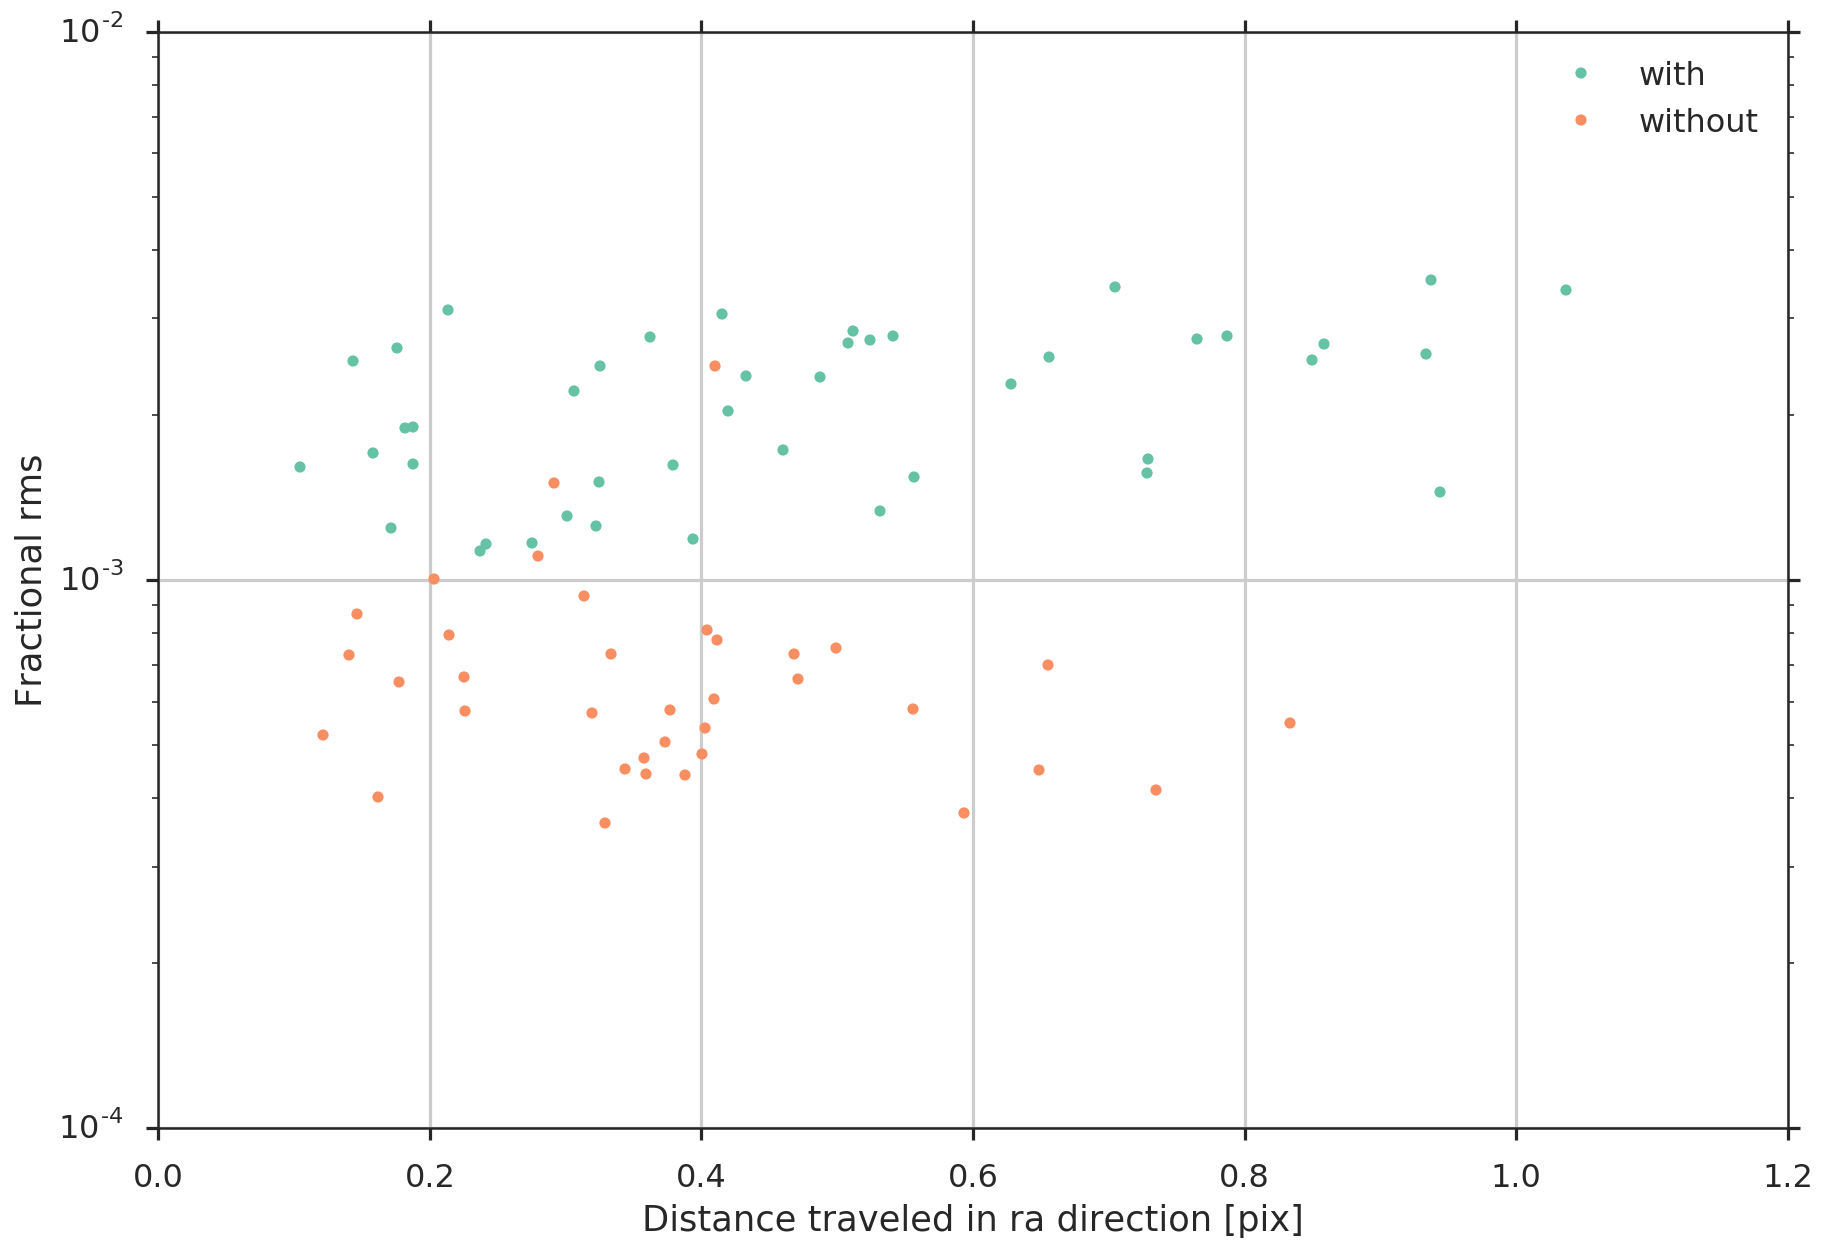

In [8]:
fig, ax = plt.subplots()
for trend, group in aperture_list.groupby('trend'):
    ax.plot(group['distance_x'], group['frms'], '.', label=trend)
ax.set(yscale='log', xlabel='Distance traveled in ra direction [pix]', ylabel='Fractional rms')
ax.grid(True)
ax.legend(loc='best')
fig.tight_layout()

Trouble is with so few points it's going to be very hard to see trends. Perhaps the stars with trends move further in the RA direction? This is in the X axis of the chip as the detector is rotated 180 degrees on the sky.

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


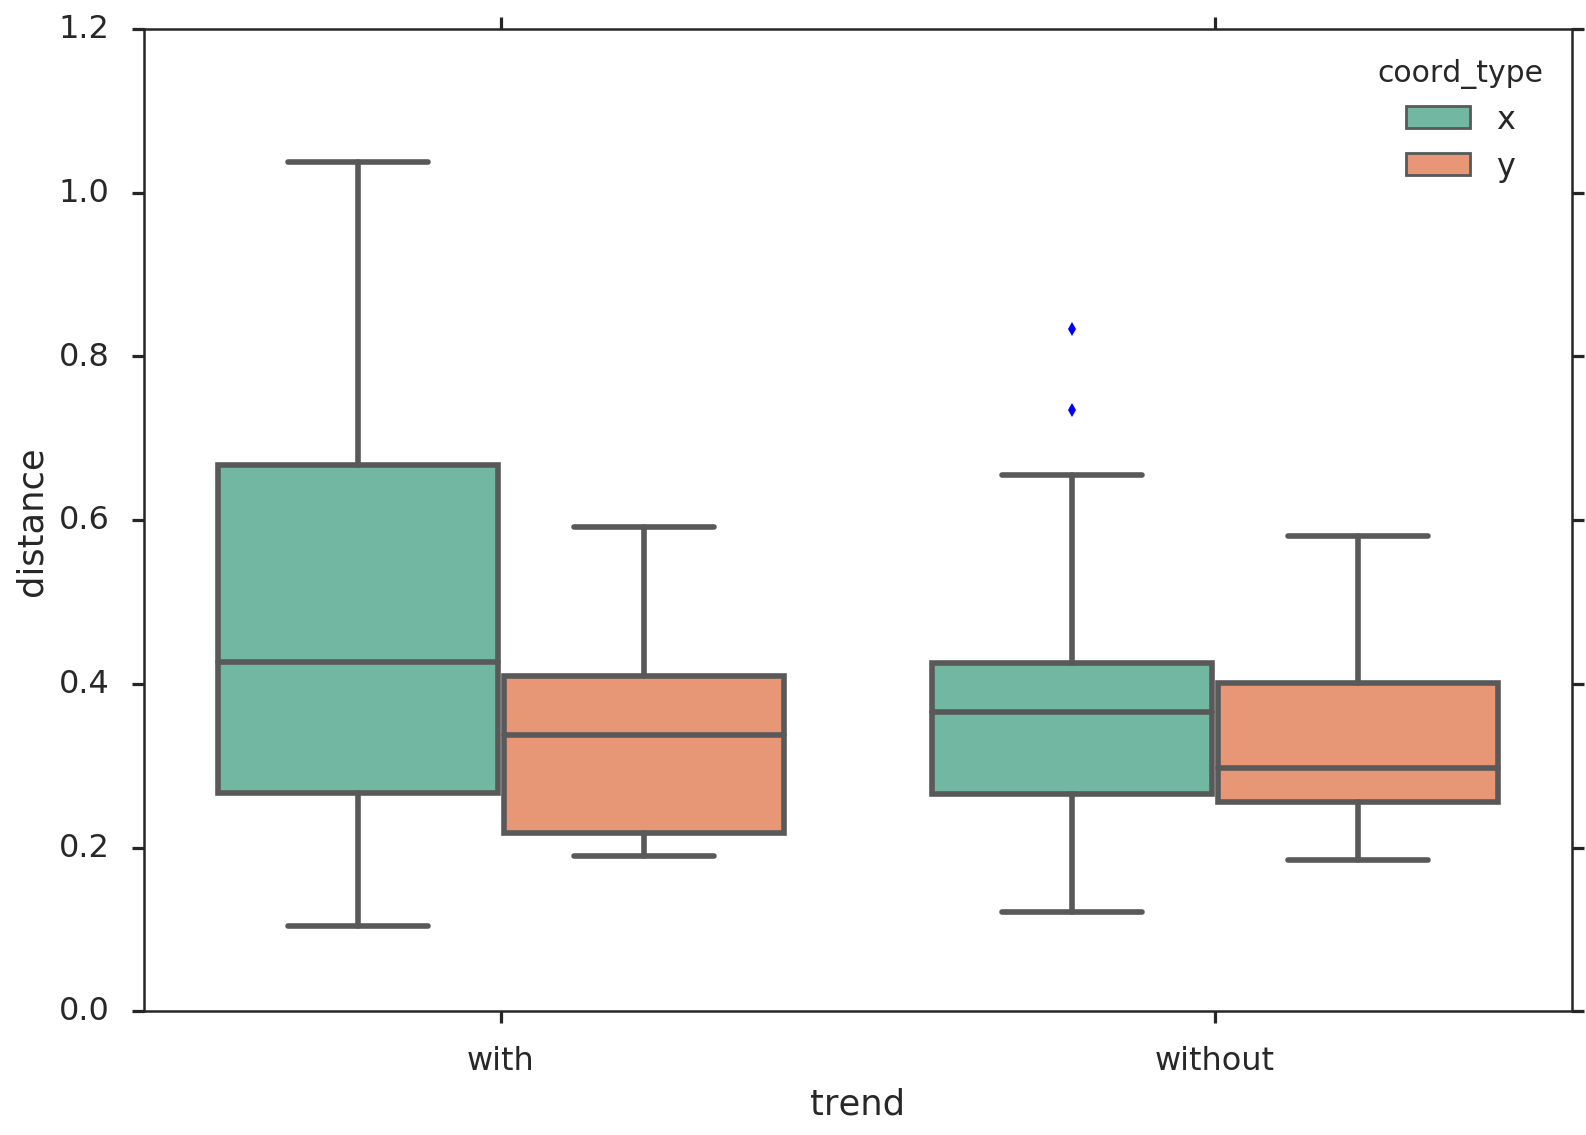

In [9]:
# Build a temporary data frame object to hold the coordinate data, for
# nicer plotting with `boxplot`
trends = np.hstack([aperture_list['trend'], aperture_list['trend']])
coords = np.hstack([aperture_list['distance_x'], aperture_list['distance_y']])
coord_type = np.hstack([np.array(['x'] * len(aperture_list)), np.array(['y'] * len(aperture_list))])
df = pd.DataFrame({'trend': trends, 'distance': coords, 'coord_type': coord_type})

sns.boxplot(data=df, x='trend', y='distance', hue='coord_type')

In [10]:
df.groupby(['trend', 'coord_type']).median()

distance
trend   coord_type          
with    x           0.426208
        y           0.338080
without x           0.366198
        y           0.297406

All apertures show more movement in the x (RA) direction. Stars with trends show a higher ratio of x movement to y movement.

# Generating thumbnails

We now look at thumbnails for each aperture. First get the thumbnail data from the chosen file. Then get the coordinates from the pipeline, then get the coordinates from the WCS solution.

## Extract the thumbnails

Get the thumbnail file.

I use the night of 2015-09-11, and using the database pick a low airmass file.

First we get the autoguider residuals for that night to compute the rejection criteria for images.

In [11]:
engine = create_engine('mysql+pymysql://sw@ngtsdb/ngts_ops')
query = '''select x_error, y_error from autoguider_log
join raw_image_list using (image_id)
where camera_id = 802
and night = "2015-09-11"
and image_class = "SCIENCE"
and field like "NG200%%"'''
ag = pd.read_sql_query(query, engine)

0.35448710233 0.257347694522


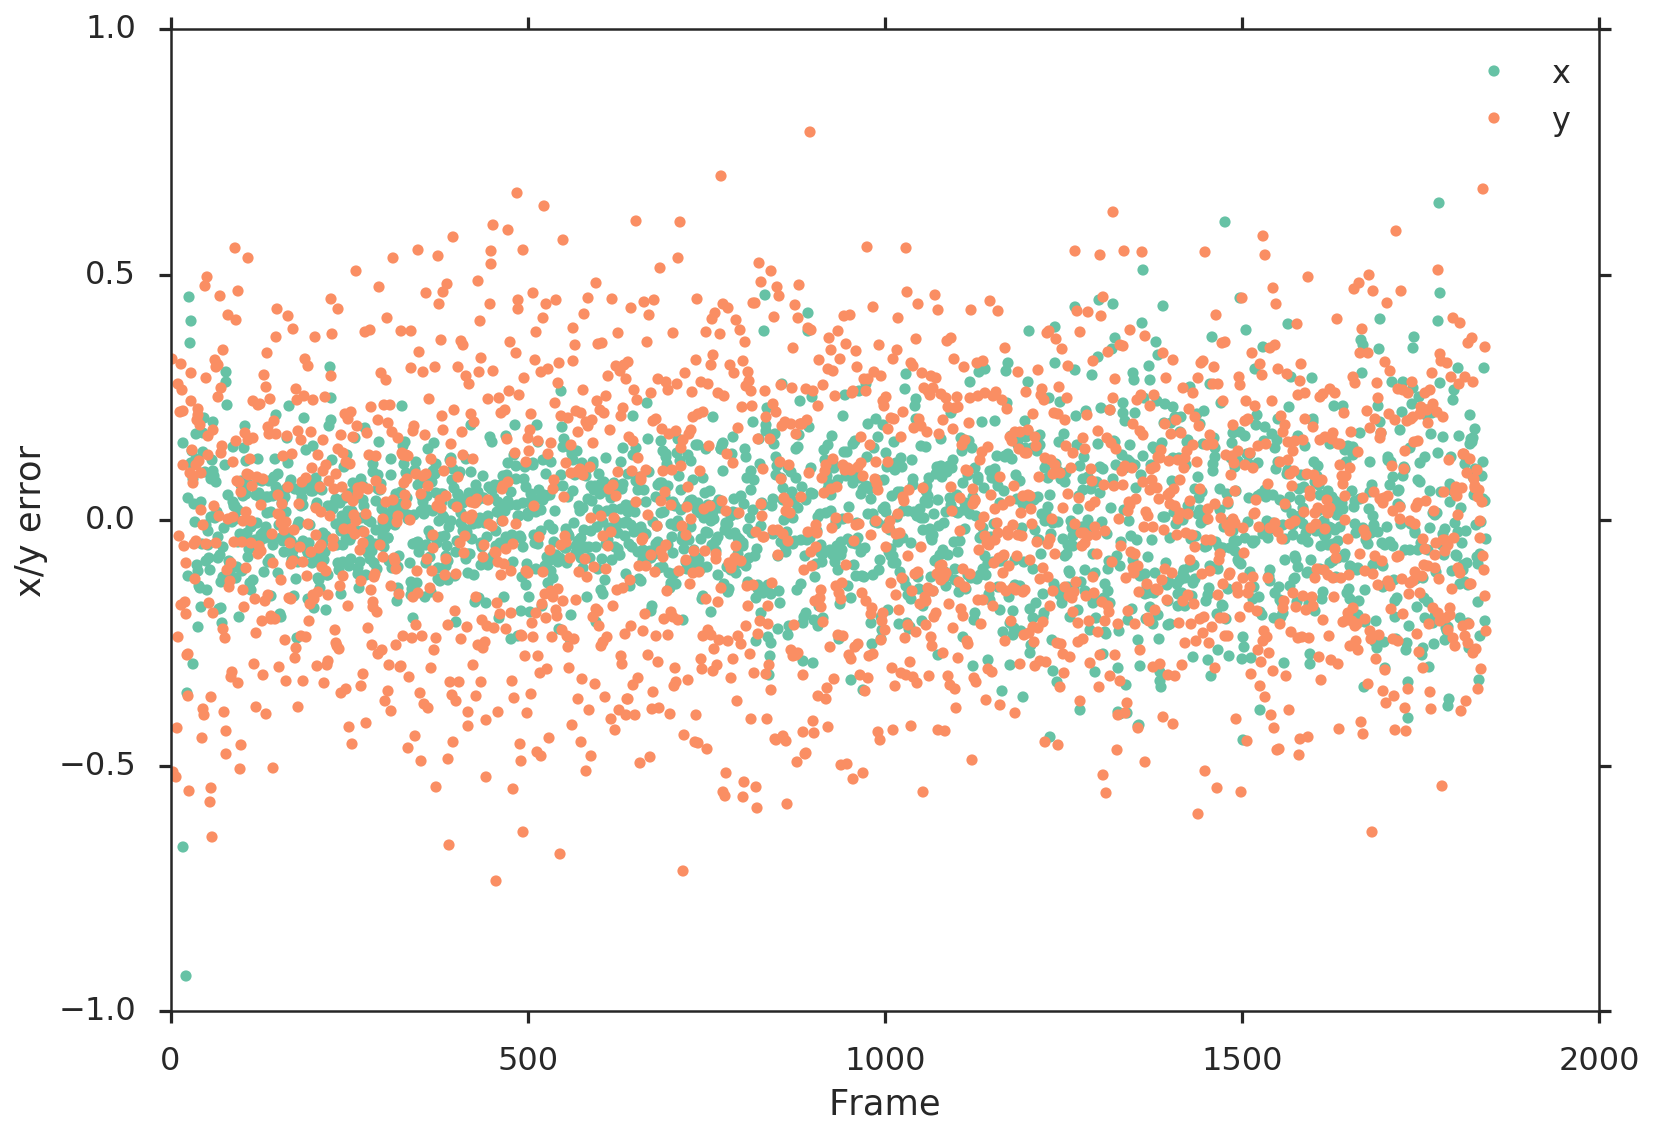

In [12]:
x_error, y_error = [sigma_clip(data) for data in [ag['x_error'], ag['y_error']]]
plt.plot(x_error, '.', label='x')
plt.plot(y_error, '.', label='y')
plt.ylim(-1, 1)
plt.xlabel('Frame')
plt.ylabel('x/y error')
plt.legend(loc='best')

sigma_x, sigma_y = [data.std() for data in [x_error, y_error]]
print(sigma_x, sigma_y)

We use these sigma values to set limits on the autoguider exertion.

In [13]:
query = '''select image_id, airmass
    from raw_image_list
    join autoguider_log using (image_id)
    where night = "2015-09-11"
    and image_class = "SCIENCE"
    and abs(x_error) < %s
    and abs(y_error) < %s
    and camera_id = 802
    and field like "NG200%%"
    order by airmass asc
    limit 1'''
connection = engine.connect()
rows = connection.execute(query, (float(sigma_x), float(sigma_y)))
image_id, airmass = rows.fetchone()
    
print('Chosen image %d. Airmass: %f' % (image_id, airmass))

Chosen image 80220150912011938. Airmass: 1.065970


In [14]:
image_ind = np.where(imagelist['IMAGE_ID'] == image_id)[0][0]
print('Image index: %d' % image_ind)

Image index: 460


In [15]:
filename = 'procIMAGE{image_id}.fits'.format(image_id=image_id)
root_dir = '/ngts/pipedev/ParanalOutput/detrending_subset/reduced_data/20150911'
full_path = os.path.join(root_dir, filename)
assert os.path.isfile(full_path)

Extract the image data from this file.

In [16]:
with fitsio.FITS(full_path) as infile:
    header = infile[0].read_header()
    full_image = infile[0].read()

Let's also get the master flat image data, and the sky background map

In [17]:
mflat_name = '/ngts/pipedev/custom_flats/mastervig_802.fits'
skybkg_name = '../data/skybkgmap.fits'
mflat = fitsio.read(mflat_name)
skybkg_frame = fitsio.read(skybkg_name)

## Pipeline coordinates

In [18]:
aperture_list['x_pipeline'] = ccdx_sample[:, image_ind]
aperture_list['y_pipeline'] = ccdy_sample[:, image_ind]

## WCS coordinates

In [19]:
wcs = WCS(header)
x, y = wcs.all_world2pix(aperture_list['ra'], aperture_list['dec'], 1)
aperture_list['x_wcs'] = x
aperture_list['y_wcs'] = y

Build a KDTree of the positions of all objects in the input catalogue.

In [20]:
x_image, y_image = ccdx[:, image_ind], ccdy[:, image_ind]
tree = KDTree(np.stack([x_image, y_image]).T)

In [21]:
# Value object to hold the thumbnail information
ThumbnailBase = namedtuple('ThumbnailBase',
                       ['index', 'data', 'mflat', 'skymap', 'dx', 'dy', 'xmin', 'xmax',
                        'ymin', 'ymax', 'has_trend', 'nn_distance'])

class Thumbnail(ThumbnailBase):
    def plot(self, data_type, render_title=True, axis=None):
        '''
        Plot a thumbnail on an axis.

        * show the thumbnail data
        * for each object in the list, place a circular aperture
        '''
        axis = axis if axis is not None else plt.gca()
        if data_type == 'data':
            im = scale_image(self.data, scale='log')
        elif data_type == 'mflat':
            im = scale_image(self.mflat)
        elif data_type == 'skymap':
            im = scale_image(self.skymap)
        axis.imshow(im,
                    origin='lower',
                    interpolation='None',
                    extent=[self.xmin, self.xmax, self.ymin, self.ymax])
        patches = []
        for (dx, dy) in zip(self.dx, self.dy):
            patches.append(plt.Circle((self.xmin + dx, self.ymin + dy), 3, edgecolor='g', fill=False, linewidth=3))
        axis.add_collection(PatchCollection(patches, match_original=True))
        if render_title:
            axis.set(title='Aperture {0:d}; has trend: {1}'.format(int(self.index), self.has_trend))

In [22]:
margin = 16       # Thumbnail half-width
thumbnails = {}
for _, row in aperture_list.iterrows():
    # Get the image limits
    x, y = np.round(row['x_wcs']).astype(int), np.round(row['y_wcs']).astype(int)
    xlim = (x - margin, x + margin)
    ylim = (y - margin, y + margin)
    
    # Aperture position in the thumbnail
    dx, dy = (row['x_wcs'] - x + margin - 0.5, row['y_wcs'] - y + margin - 0.5)
    
    # Thumbnail data
    thumbnail = full_image[ylim[0]:ylim[1], xlim[0]:xlim[1]]
    mflat_thumbnail = mflat[ylim[0]:ylim[1], xlim[0]:xlim[1]]
    skymap_thumbnail = skybkg_frame[ylim[0]:ylim[1], xlim[0]:xlim[1]]
    
    # Get the nearest neighbours from the KDTree
    object_inds = tree.query_ball_point([xlim[0] + dx, ylim[0] + dy], np.sqrt(2) * margin)
    
    # Get the distance to the nearest neighbour
    nn_distance, _ = tree.query([xlim[0] + dx, ylim[0] + dx])
    
    # For each neighbour, compute the relative aperture coordinates on the thumbnail
    dxs, dys = [], []
    for i in object_inds:
        xx, yy = x_image[i], y_image[i]
        dxs.append(xx - x + margin - 0.5)
        dys.append(yy - y + margin - 0.5)
    
    # Generate the `Thumbnail` object
    thumbnails[row['aperture']] = Thumbnail(index=row['aperture'],
                                            data=thumbnail, dx=dxs, dy=dys,
                                            xmin=xlim[0], xmax=xlim[1],
                                            ymin=ylim[0], ymax=ylim[1],
                                            nn_distance=nn_distance,
                                            has_trend=row['trend'] == 'with',
                                            mflat=mflat_thumbnail,
                                            skymap=skymap_thumbnail)

Render the thumbnails to both the notebook and to static png images

In [23]:
!rm thumbnails/*.png 2>/dev/null
with sns.plotting_context('paper'):
    for aperture in thumbnails:
        thumbnail = thumbnails[aperture]
        fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
        for data_type, axis in zip(['data', 'mflat', 'skymap'], axes):
            thumbnail.plot(axis=axis, data_type=data_type)
        fig.tight_layout()
        fig.savefig('thumbnails/aperture-{i}-{trend_info}.png'.format(
                i=aperture, trend_info='with-trend' if thumbnail.has_trend else 'without-trend'))
        plt.close(fig)

And compress the images for transfer later

In [24]:
%%sh

rm thumbnails/images.tar.gz 2>/dev/null
tar czf thumbnails/images.tar.gz thumbnails/*.png

It is not clear looking at these thumbnails that stars with trends have nearby neighbours. Perhaps there is a correlation with distance to the nearest neighbour.

## Nearest neighbour distance

We computed the distance to the nearest neighbour. If we split the sample into with-trend and without-trend, is there a significant distance in nearest neighbour distance?

In [25]:
aperture_list['nn_distance'] = np.array(
    [thumbnails[row['aperture']].nn_distance for (_, row) in aperture_list.iterrows()])

/home/sw/work/NGTS/lightcurve-visualiser/venv/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


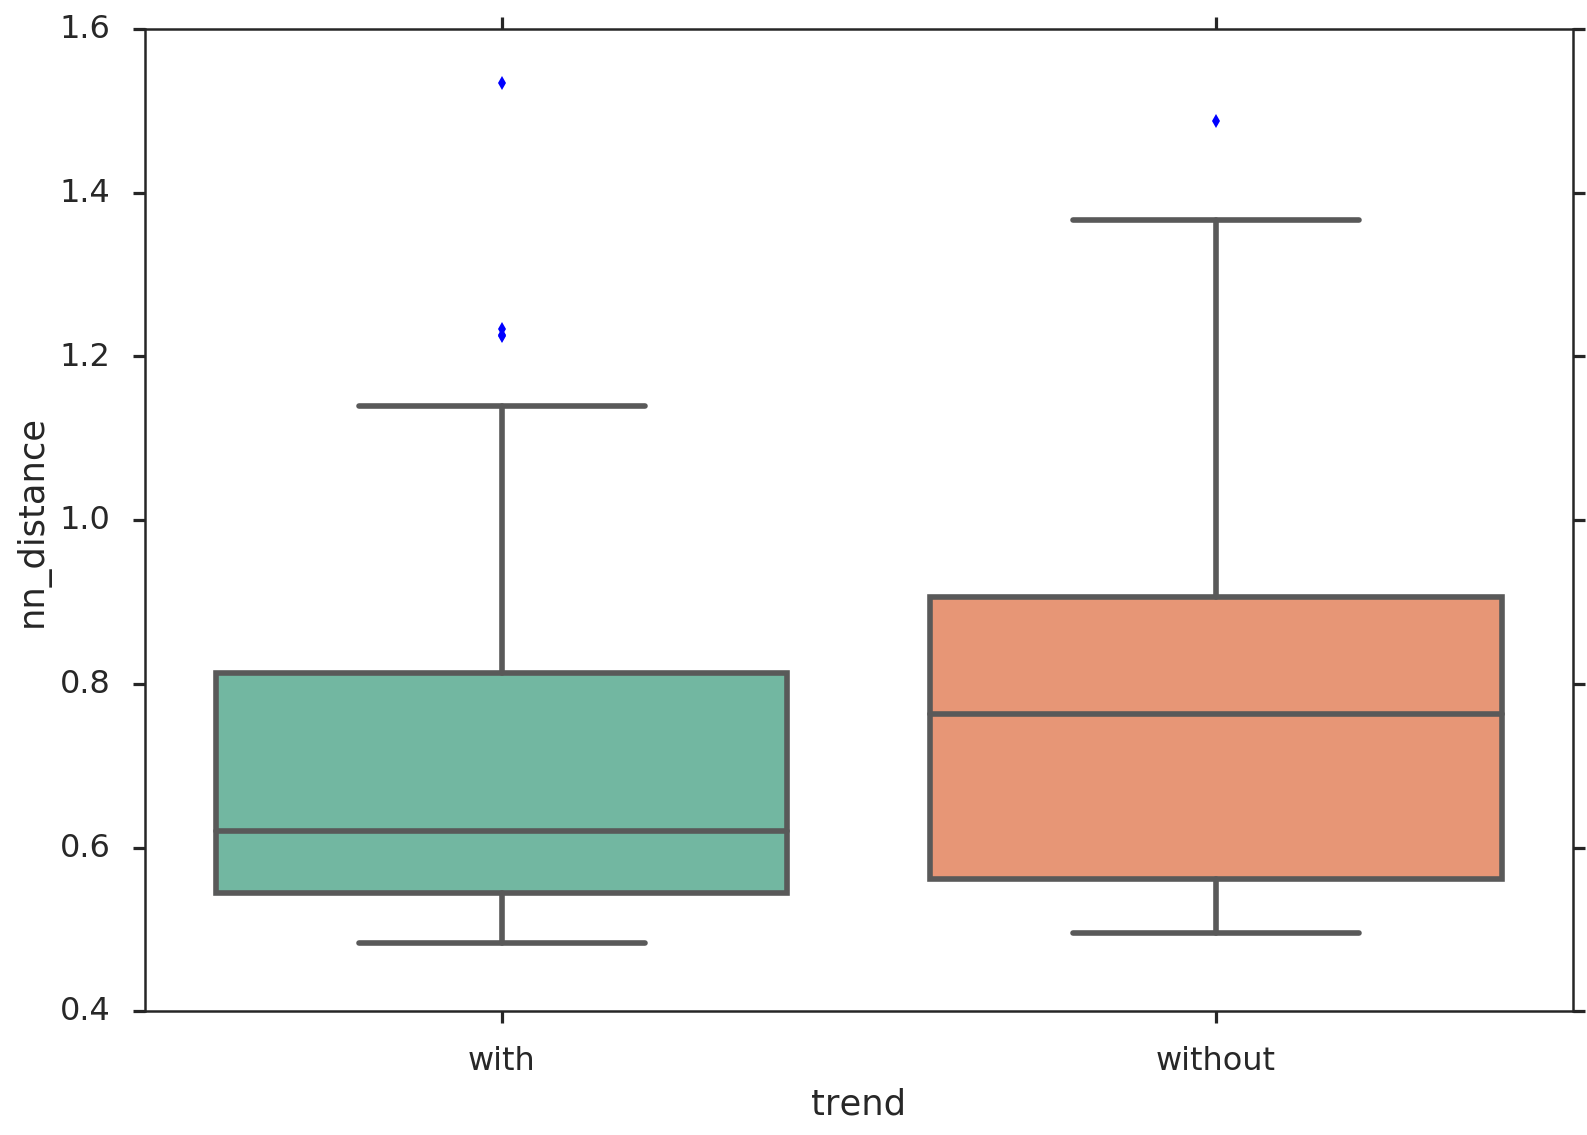

In [26]:
sns.boxplot(data=aperture_list, x='trend', y='nn_distance')

The median nearest neighbour distance is further away for stars without a trend, but the quartiles overlap significantly and the range for stars without a trend is narrower.

## Colour estimation

There does not seem to be a correlation with nearby companion, perhaps there is a trend with colour.

In [27]:
# Extract the 2MASS colours from the cross-matched reference catalogue
with fitsio.FITS('../ng2000-matched-catalogue.fits') as infile:
    ref_cat = infile[1].read()

jmag, hmag, kmag = [ref_cat[key] for key in ['Jmag_ppmxl', 'Hmag_ppmxl', 'Kmag_ppmxl']]
aperture_list['jmh'] = (jmag - hmag)[aperture_list['aperture'].values]
aperture_list['jmk'] = (jmag - kmag)[aperture_list['aperture'].values]
aperture_list['hmk'] = (hmag - kmag)[aperture_list['aperture'].values]

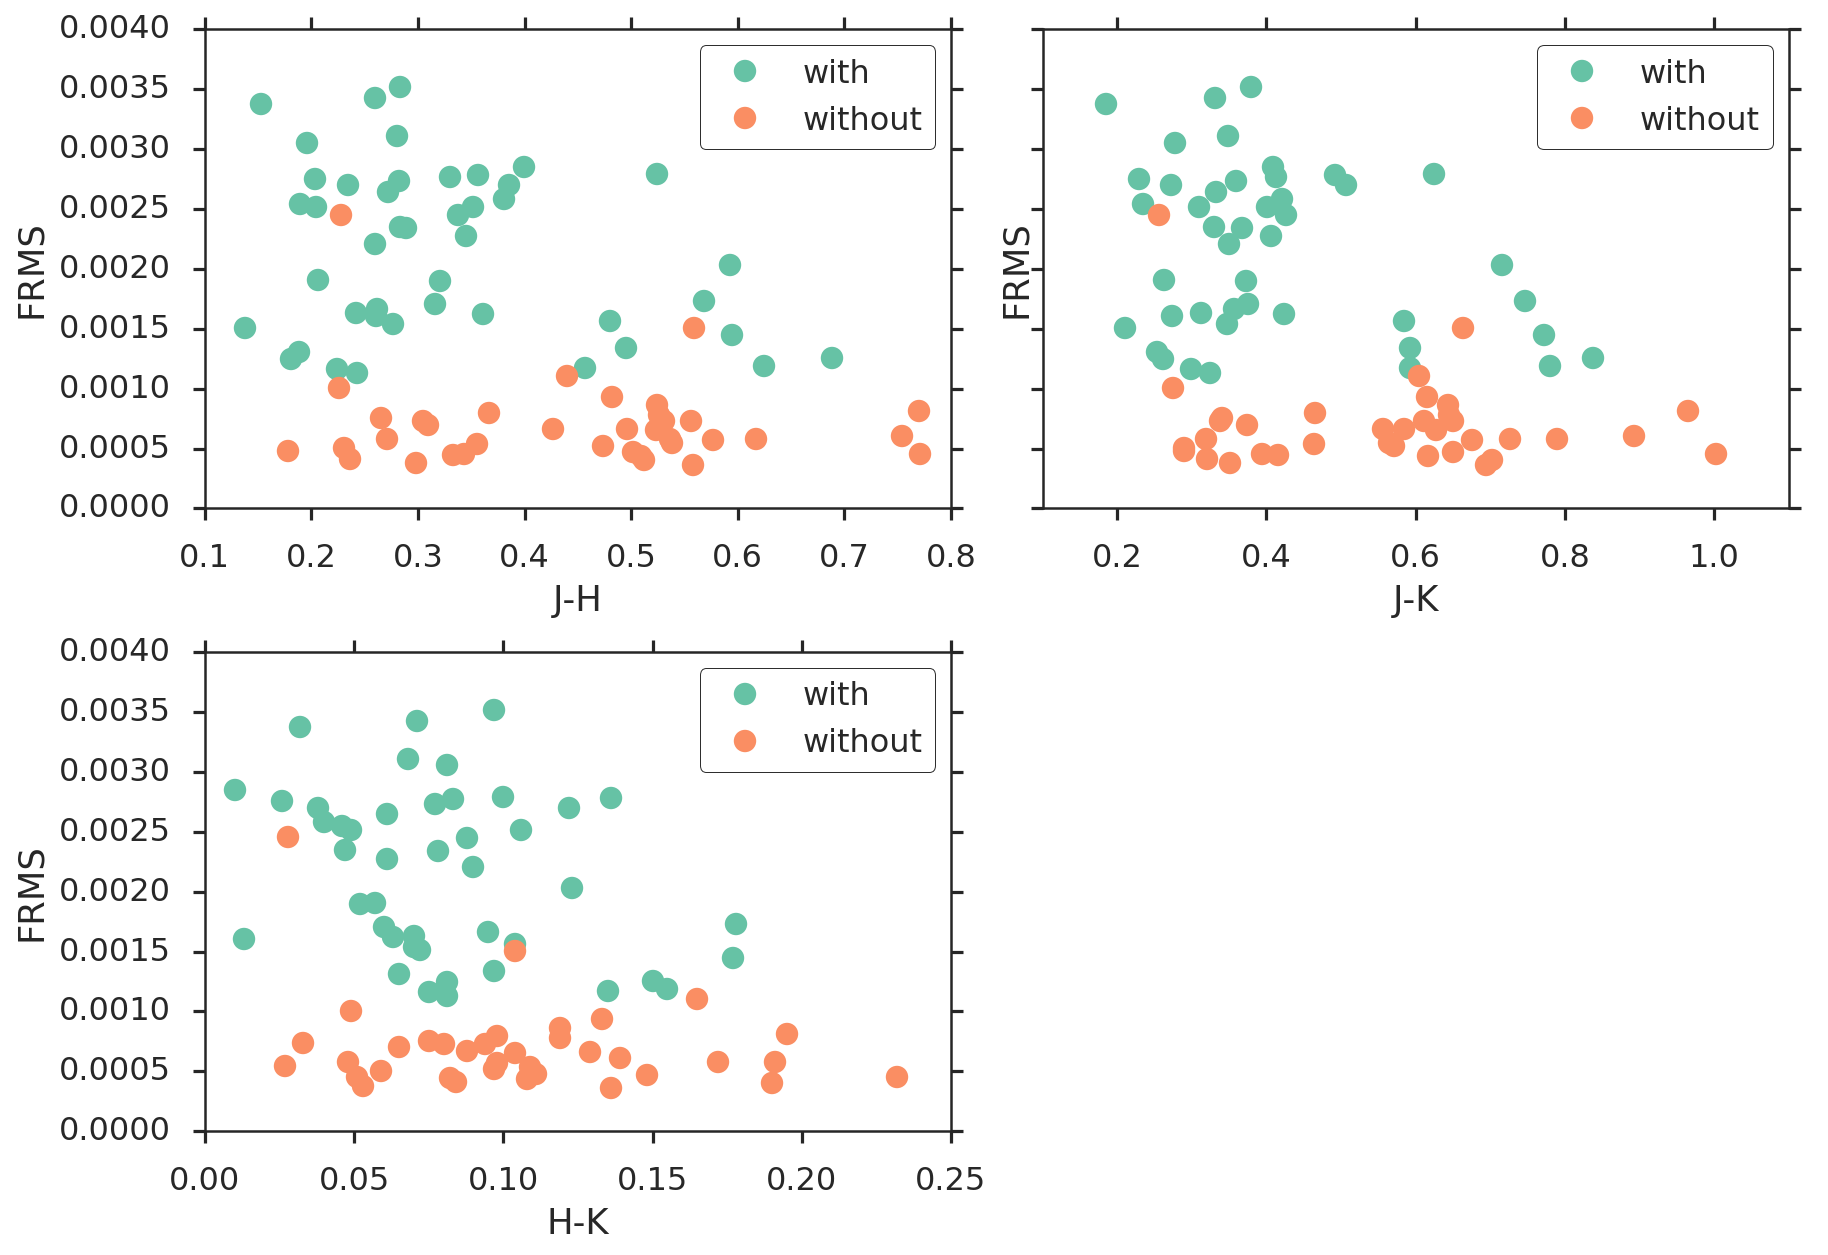

In [28]:
labels = {'jmh': 'J-H', 'jmk': 'J-K', 'hmk': 'H-K'}
with_trend = aperture_list['trend'] == 'with'
without_trend = ~with_trend
fig, axes = plt.subplots(2, 2, sharey=True)
for (ax, colour) in zip(axes.ravel(), ['jmh', 'jmk', 'hmk']):
    for ind, group in zip([with_trend, without_trend], ['with', 'without']):
        ax.plot(aperture_list[colour][ind], aperture_list['frms'][ind], 'o', label=group)
    ax.set(xlabel=labels[colour], ylabel='FRMS')
    ax.legend(loc='best', frameon=True)
axes.ravel()[-1].axis('off')
fig.tight_layout()

There is no correlation with 2MASS colours.

## Correlation with RA

Dan previously found a correlation with RA:

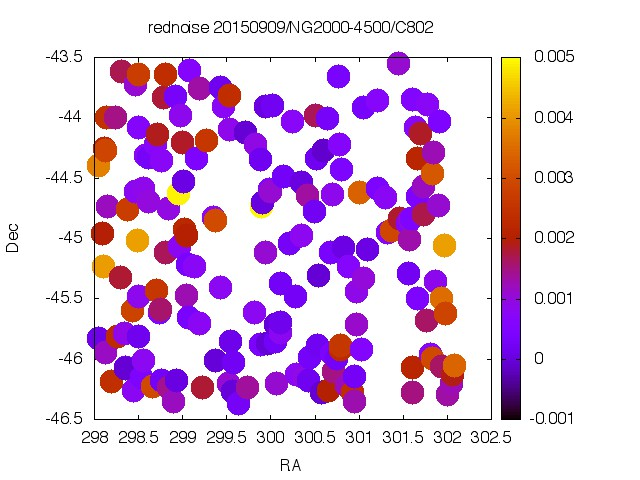

In [29]:
from IPython.display import Image
Image(filename='dan-noise.png')

Do we see this in our data?

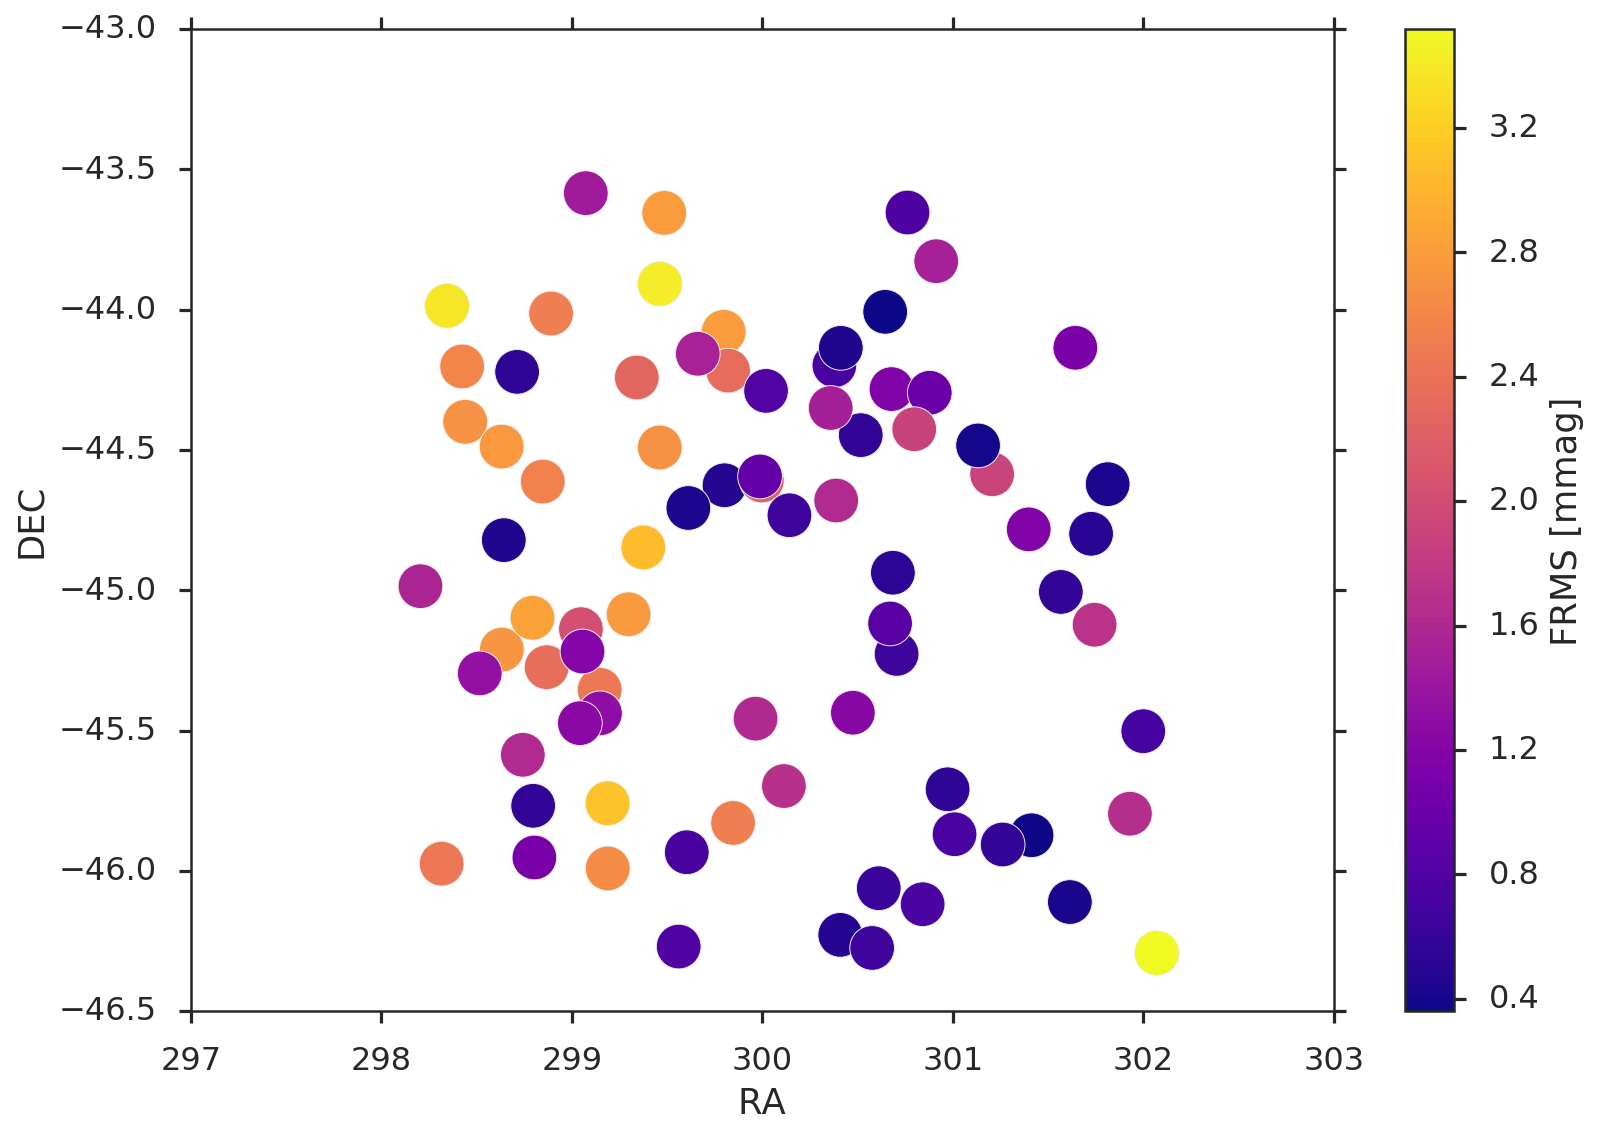

In [30]:
fig, axis = plt.subplots()
sc = axis.scatter(aperture_list['ra'], aperture_list['dec'], s=500, c=aperture_list['frms'] * 1000, cmap='plasma')
axis.set(xlabel='RA', ylabel='DEC')
cbar = fig.colorbar(sc, ax=axis)
cbar.set_label('FRMS [mmag]')

Again with this few objects the results are fairly inconclusive, but there does seem to be a population of high frms objects at lower RA. There is that one extremely high noise object in the bottom right corner though...

# Performing photometry on the flat frame

We take the aperture positions for each object in the sample, and perform aperture photometry on the master flat frame. Compute the per-pixel average flat value.

Get the files to extract.

In [31]:
files = glob.glob('/ngts/pipedev/ParanalOutput/detrending_subset/reduced_data/20150911/proc*.fits')

In [32]:
def object_coordinates(aperture_list, header):
    '''
    For a list of objects and header object, return the computed x and y coordinates
    from the astrometric solution and catalogue coordinates.
    '''
    wcs = WCS(header)
    x, y = wcs.all_world2pix(aperture_list['ra'], aperture_list['dec'], 1)
    return x, y

In [33]:
# Encapsulate results
PhotometryResult = namedtuple('PhotometryResult', ['mjd', 'average_flats'])

In [34]:
def extract_data(fname, aperture_list):
    '''
    Function to extract the mean flat value from a frame, along with the mjd
    '''
    header = fitsio.read_header(fname)
    x, y = object_coordinates(aperture_list, header)
    apertures = CircularAperture(list(zip(x, y)), r=3)
    phot_table = aperture_photometry(mflat, apertures)
    fluxes = (phot_table['aperture_sum'] / (np.pi * 3. ** 2)).data
    return PhotometryResult(mjd=header['MJD'], average_flats=fluxes)

In [35]:
# Parallel process the files
executor = ProcessPoolExecutor()
fn = partial(extract_data, aperture_list=aperture_list)
results = sorted(executor.map(fn, files), key=lambda entry: entry.mjd)

In [36]:
flat_lightcurves = np.array([entry.average_flats for entry in results]).T

In [45]:
with_trend_index = np.random.choice(np.where((aperture_list['trend'] == 'with'))[0])
without_trend_index = np.random.choice(np.where((aperture_list['trend'] == 'without'))[0])

print(with_trend_index, without_trend_index)

print("With trend: %d" % aperture_list.iloc[with_trend_index]['aperture'])
print("Without trend: %d" % aperture_list.iloc[without_trend_index]['aperture'])

32 15
With trend: 11511
Without trend: 7822


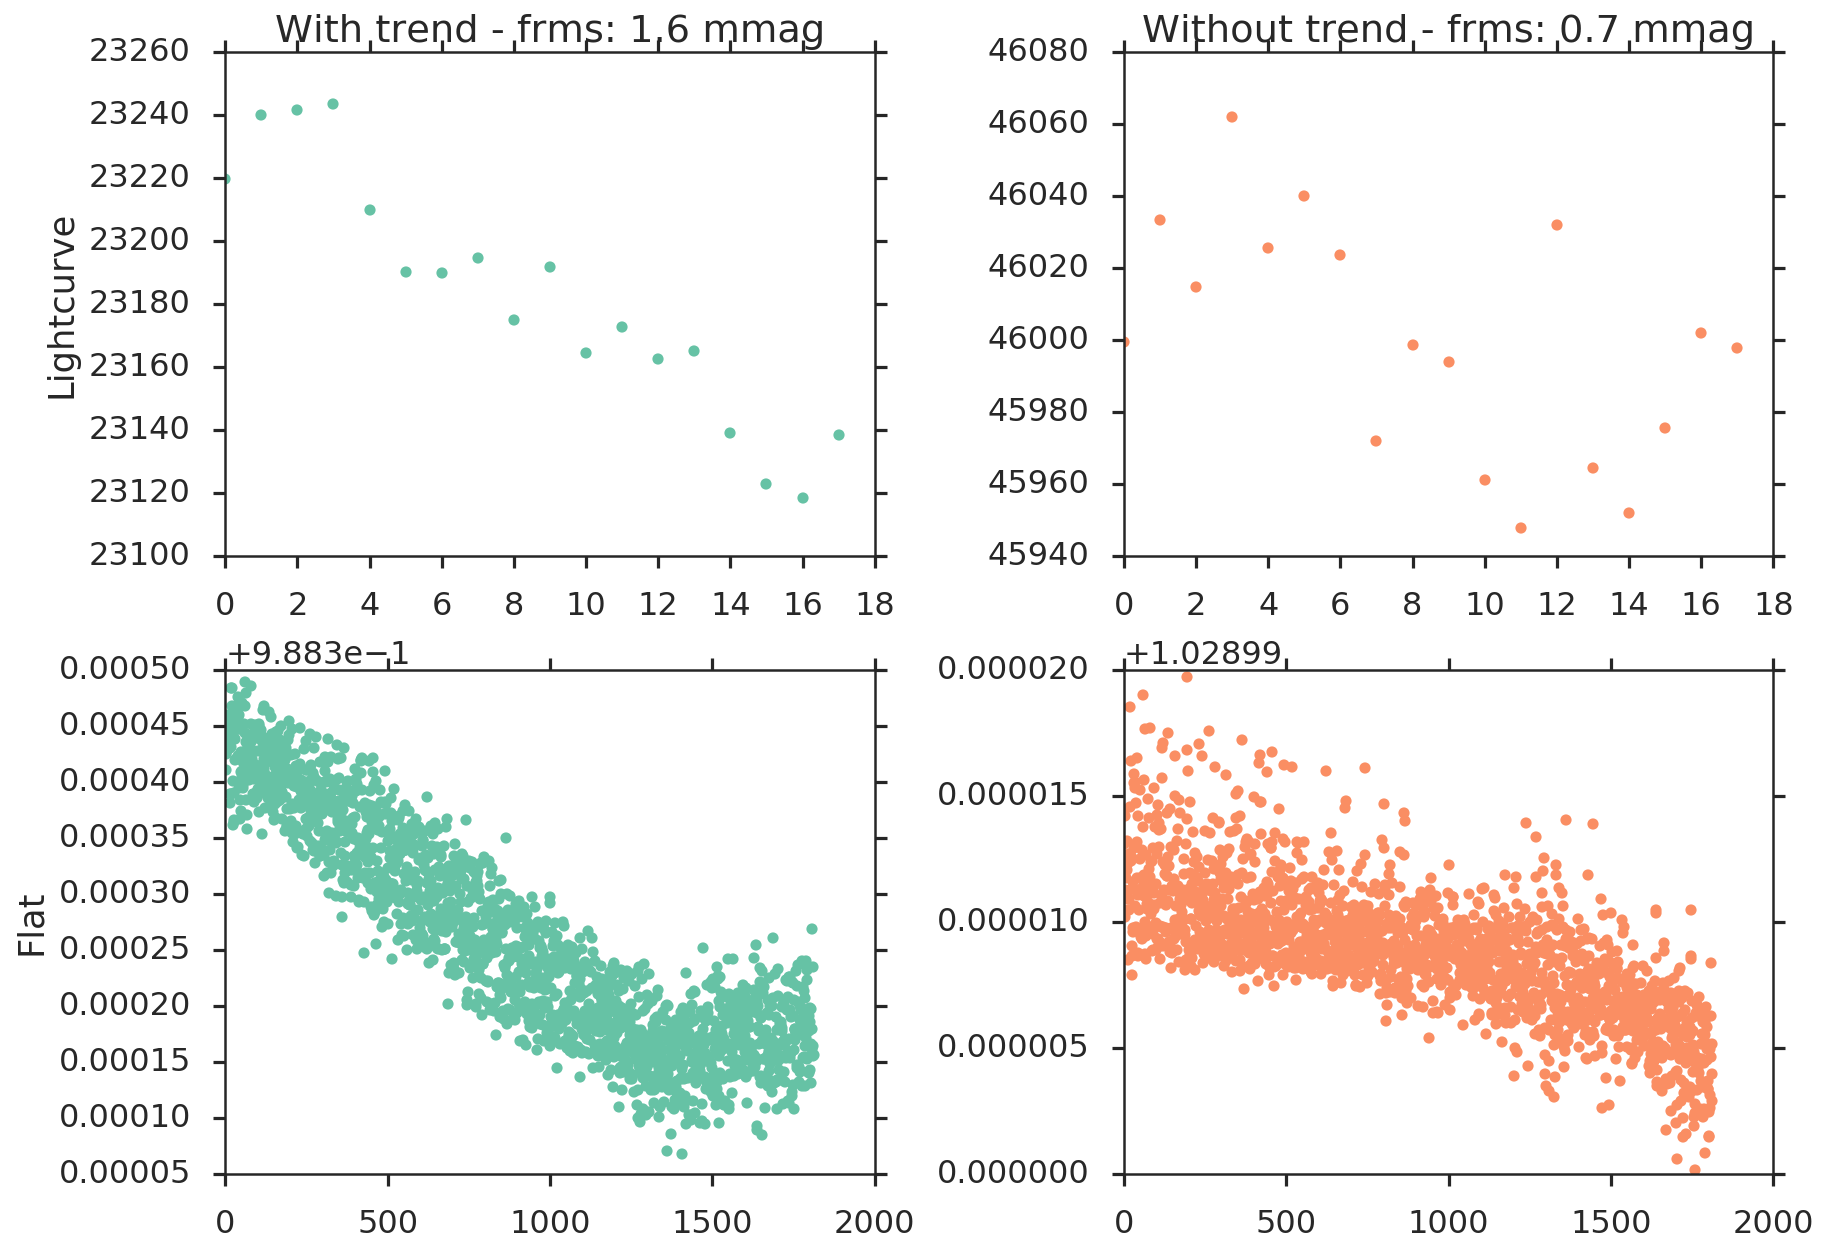

In [41]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(binned_lcs[with_trend_index], '.')
axes[0, 1].plot(binned_lcs[without_trend_index], '.', color=colours[1])
axes[1, 0].plot(flat_lightcurves[with_trend_index, 30:], '.')
axes[1, 1].plot(flat_lightcurves[without_trend_index, 30:], '.', color=colours[1])
axes[0, 0].set(title='With trend - frms: {:.1f} mmag'.format(
        binned_lcs[with_trend_index].std() * 1000 / binned_lcs[with_trend_index].mean()), ylabel='Lightcurve')
axes[0, 1].set(title='Without trend - frms: {:.1f} mmag'.format(
        binned_lcs[without_trend_index].std() * 1000 / binned_lcs[without_trend_index].mean()))
axes[1, 0].set(ylabel='Flat')
fig.tight_layout()

I don't particularly see any effect with flat value.